In [1]:
import pandas as pd
import re
from datetime import datetime
import numpy as np
from urllib.parse import urlparse

# Corrected: removed duplicate 'dest_domain'
REQUIRED_COLUMNS = [
    'timestamp', 'user', 'action', 'description', 'protocol', 'url', 'method',
    'source_ip', 'dest_ip', 'dest_domain', 'client_ip', 'source_port',
    'dest_port', 'severity', 'host', 'rule_name', 'app', 'category',
    'bytes_sent', 'bytes_received', 'threat_id', 'user_agent', 'eventid',
    'workstation', 'privilege', 'object', 'accessmask', 'target', 'status',
    'reason', 'process', 'parentprocess', 'fileaccessed', 'alert', 'machine',
    'os', 'details', 'resource', 'hostname', 'location', 'facility', 'code',
    'message', 'event', 'file', 'verdict', 'log_type'
]

def clean_csv_log(file_path, log_type):
    try:
        df = pd.read_csv(file_path)
        df.dropna(how='all', inplace=True)
        df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]
        df['log_type'] = log_type
        return df
    except Exception as e:
        print(f"[!] Error reading {file_path}: {e}")
        return pd.DataFrame(columns=REQUIRED_COLUMNS)

def normalize_timestamp(ts):
    try:
        return datetime.strptime(ts, '%Y-%m-%d %H:%M:%S').isoformat()
    except Exception:
        return None

def clean_ip_column(ip):
    ip_pattern = r'^(\d{1,3}\.){3}\d{1,3}$'
    if isinstance(ip, str) and re.match(ip_pattern, ip):
        return ip
    return np.nan

def clean_domain_column(domain):
    domain_pattern = r'^[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
    if isinstance(domain, str) and re.match(domain_pattern, domain):
        return domain.lower()
    return np.nan

def map_ad_columns(df):
    ip_fields = ['client_ip', 'client_address', 'ip_address', 'ip']
    client_ip_col = next((col for col in ip_fields if col in df.columns), None)
    
    if client_ip_col:
        df['client_ip'] = df[client_ip_col]
    else:
        df['client_ip'] = None

    col_map = {
        'user': 'user',
        'description': 'description',
        'timestamp': 'timestamp'
    }
    col_map = {k: v for k, v in col_map.items() if k in df.columns}
    df = df.rename(columns=col_map)
    return df

def map_proxy_columns(df):
    ip_fields = ['client', 'client_ip', 'source_ip', 'ip']
    for field in ip_fields:
        if field in df.columns:
            df['client_ip'] = df[field].astype(str).str.extract(r'(\d{1,3}(?:\.\d{1,3}){3})')[0]
            break
    else:
        df['client_ip'] = None

    if 'url' in df.columns:
        df['hostname'] = df['url'].apply(lambda x: urlparse(str(x)).hostname if pd.notnull(x) else None)

    return df

def map_firewall_columns(df):
    if 'dest_ip' in df.columns:
        df['dest_domain'] = df['dest_ip'].apply(
            lambda x: x if isinstance(x, str) and not re.match(r'^(\d{1,3}\.){3}\d{1,3}$', x) else np.nan
        )
        df['dest_ip'] = df['dest_ip'].apply(clean_ip_column)
    return df

# Define your input files
log_files = {
    "firewall": "./logs/firewall_logs.csv",
    "proxy": "./logs/proxy_logs.csv",
    "ad": "./logs/ad_logs.csv",
    "edr": "./logs/edr_logs.csv",
    "iam": "./logs/iam_logs.csv",
    "mail": "./logs/mail_logs.csv",
    "router": "./logs/router_logs.csv",
    "user": "./logs/user.csv",
    "siem": "./logs/siem_logs.csv"
}

dataframes = []
for log_type, file_path in log_files.items():
    df = clean_csv_log(file_path, log_type)

    if df.empty:
        continue

    if log_type == 'ad':
        df = map_ad_columns(df)
    elif log_type == 'proxy':
        df = map_proxy_columns(df)
    elif log_type == 'firewall':
        df = map_firewall_columns(df)
    else:
        df['client_ip'] = None
        df['dest_domain'] = None

    # Ensure all required columns exist
    for col in REQUIRED_COLUMNS:
        if col not in df.columns:
            df[col] = None

    df = df[REQUIRED_COLUMNS]  # Reorder and limit columns
    dataframes.append(df)

# Concatenate all processed logs
final_dataset = pd.concat(dataframes, ignore_index=True)

# Normalize timestamps
final_dataset['timestamp'] = final_dataset['timestamp'].apply(normalize_timestamp)

# Clean IP fields
for ip_col in ['source_ip', 'dest_ip', 'client_ip']:
    final_dataset[ip_col] = final_dataset[ip_col].apply(clean_ip_column)

# Clean domain fields
final_dataset['domain'] = final_dataset['hostname'].apply(clean_domain_column)
final_dataset['dest_domain'] = final_dataset['dest_domain'].apply(clean_domain_column)

# Drop temporary hostname column
final_dataset.drop(columns=['hostname'], inplace=True)

# Save final output
final_dataset.to_csv("normalized_logs.csv", index=False)
print("[✓] All logs cleaned, normalized, and saved to normalized_logs.csv")

[✓] All logs cleaned, normalized, and saved to normalized_logs.csv


/tmp/ipykernel_1625/3043133616.py:127: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_dataset = pd.concat(dataframes, ignore_index=True)


In [2]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('normalized_logs.csv')

# Convert 'event_time' to datetime, coercing errors to NaT (Not a Time)
# This handles cases where some time entries might not be in a standard format
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Drop rows where 'event_time' could not be parsed (NaT values)
df.dropna(subset=['timestamp'], inplace=True)

# Sort the DataFrame by 'event_time'
df_sorted = df.sort_values(by='timestamp')

# Save the sorted DataFrame to a new CSV file
output_file_name = 'logs_sorted_by_time.csv'
df_sorted.to_csv(output_file_name, index=False)

print(f"\nLogs sorted by time saved to {output_file_name}")


Logs sorted by time saved to logs_sorted_by_time.csv


In [3]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("logs_sorted_by_time.csv")

# Normalize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

# Drop empty rows and columns
df.dropna(how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)

# Clean strings (skip these fields)
exclude_clean = ['user_agent', 'url', 'fileaccessed', 'message']
for col in df.select_dtypes(include='object').columns:
    if col not in exclude_clean:
        df[col] = df[col].astype(str).str.strip().str.lower()

# Convert timestamp
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    df = df[df['timestamp'].notna()]

# Standardize event IDs
for field in ['eventid', 'threat_id']:
    if field in df.columns:
        df[field] = df[field].replace(['', ' ', 'nan', 'None', None], pd.NA).fillna(-1)
        try:
            df[field] = df[field].astype(int)
        except:
            pass

# IP cleanup
ip_fields = ['source_ip', 'dest_ip', 'client_ip']
for col in ip_fields:
    if col in df.columns:
        df[col] = df[col].astype(str).str.extract(r'(\d{1,3}(?:\.\d{1,3}){3})')[0].fillna('0.0.0.0')

# Port cleanup
for port in ['source_port', 'dest_port']:
    if port in df.columns:
        df[port] = pd.to_numeric(df[port], errors='coerce').fillna(0).astype(int)
        df[port] = df[port].replace(0, -1)

# Bytes cleanup
for col in ['bytes_sent', 'bytes_received']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

# Normalize categorical values
cat_fields = ['action', 'severity', 'verdict', 'log_type', 'category', 'protocol']
for col in cat_fields:
    if col in df.columns:
        df[col] = df[col].replace({'none': np.nan, 'na': np.nan, 'null': np.nan}).fillna('unknown')

# Fill general missing values
df.fillna({
    'user': 'unknown',
    'app': 'unknown',
    'rule_name': 'unknown',
    'host': 'unknown',
    'workstation': 'unknown',
    'privilege': 'unknown',
    'event': 'unknown',
    'status': 'unknown',
    'alert': 'none',
    'machine': 'unknown',
    'os': 'unknown',
    'domain': 'unknown',
    'location': 'unknown',
    'reason': 'unspecified',
    'accessmask': 'unknown',
}, inplace=True)

# Fill text fields
text_fill = {
    'url': 'unknown_url',
    'user_agent': 'unknown_agent',
    'fileaccessed': 'none',
    'message': 'no_message',
}
for col, default in text_fill.items():
    if col in df.columns:
        df[col] = df[col].fillna(default).replace('nan', default).replace('', default)

# Rename columns to consistent format
column_rename_map = {
    'timestamp': 'event_time',
    'eventid': 'event_id',
    'threat_id': 'threat_identifier',
    'user': 'user_account',
    'severity': 'event_severity',
    'log_type': 'log_source_type',
    'source_ip': 'source_ip_address',
    'dest_ip': 'destination_ip_address',
    'client_ip': 'client_ip_address',
    'dest_domain': 'destination_domain',
    'source_port': 'source_port_number',
    'dest_port': 'destination_port_number',
    'protocol': 'network_protocol',
    'action': 'security_action',
    'verdict': 'security_verdict',
    'category': 'event_category',
    'app': 'application_name',
    'rule_name': 'detection_rule',
    'bytes_sent': 'bytes_sent_total',
    'bytes_received': 'bytes_received_total',
    'url': 'resource_url',
    'method': 'http_method',
    'user_agent': 'user_agent_string',
    'description': 'event_description',
    'fileaccessed': 'file_accessed_path',
    'host': 'host_name',
    'workstation': 'workstation_name',
    'privilege': 'user_privilege_level',
    'object': 'affected_object',
    'accessmask': 'access_mask',
    'target': 'target_resource',
    'status': 'event_status',
    'reason': 'status_reason',
    'process': 'process_name',
    'parentprocess': 'parent_process_name',
    'alert': 'alert_type',
    'machine': 'machine_name',
    'os': 'operating_system',
    'event': 'raw_event_data',
    'file': 'file_path',
    'facility': 'log_facility',
    'code': 'status_code',
    'message': 'log_message',
    'details': 'event_details',
    'resource': 'resource_name',
    'location': 'event_location',
    'domain': 'network_domain'
}
df.rename(columns=column_rename_map, inplace=True)

# Reorder columns logically
ordered_columns = [
    # Event metadata
    'event_time','log_source_type' ,'event_id', 'threat_identifier',

    # User/device context
    'user_account', 'user_privilege_level', 'host_name', 'workstation_name', 'machine_name', 'operating_system',

    # Network context
    'source_ip_address', 'source_port_number', 'destination_ip_address', 'destination_port_number',
    'client_ip_address', 'destination_domain', 'network_domain', 'network_protocol',

    # Security action
    'security_action', 'event_severity', 'event_status', 'status_reason', 'event_category', 'detection_rule', 'security_verdict', 'alert_type',

    # Resource access
    'resource_url', 'http_method', 'user_agent_string', 'resource_name', 'affected_object', 'target_resource',
    'file_accessed_path', 'file_path',

    # Process/activity
    'process_name', 'parent_process_name', 'access_mask',

    # Logging & raw data
    'event_description', 'event_details', 'log_message', 'raw_event_data', 'log_facility', 'status_code', 'event_location',

    # Data volume
    'bytes_sent_total', 'bytes_received_total',

    # Extras
    'application_name'
]

# Keep only existing columns
existing_ordered_columns = [c for c in ordered_columns if c in df.columns]
remaining_columns = [c for c in df.columns if c not in existing_ordered_columns]
df = df[existing_ordered_columns + remaining_columns]

# Remove duplicates
df.drop_duplicates(inplace=True)

# Save to file
df.to_csv("dataset.csv", index=False)
print("✅ Logs cleaned, renamed, and saved as 'dataset.csv'")


✅ Logs cleaned, renamed, and saved as 'dataset.csv'


In [4]:
import pandas as pd
import random
from datetime import datetime, timedelta

# Load original dataset
original_path = "./dataset.csv"
df = pd.read_csv(original_path)

# Helper function to generate random times
def random_time(start_time, end_time, count):
    start = datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S")
    end = datetime.strptime(end_time, "%Y-%m-%d %H:%M:%S")
    return [start + timedelta(seconds=random.randint(0, int((end - start).total_seconds()))) for _ in range(count)]

# Predefined attacks to simulate
def generate_attack_logs(num_each=10):
    logs = []

    phishing_users = ['noura.benali', 'ismail.rahimi', 'yassir.ouattara']
    brute_users = ['saif.alqahtani', 'hajar.ait', 'amin.elk']
    lateral_users = ['karim.dadi', 'mohamed.hassan', 'nadia.bouk']

    times = random_time("2025-05-26 09:00:00", "2025-05-26 11:00:00", num_each * 3)

    for i in range(num_each):
        # Phishing attack
        logs.append({
            "event_time": times[i],
            "log_source_type": "firewall",
            "event_id": -1,
            "threat_identifier": "phishing",
            "user_account": random.choice(phishing_users),
            "event_description": "User clicked on suspicious email link",
            "application_name": "http",
            "log_message": "Access to known phishing domain detected",
            "bytes_sent_total": random.randint(200, 1000),
            "bytes_received_total": random.randint(1000, 4000),
        })

        # Brute force attack
        logs.append({
            "event_time": times[i + num_each],
            "log_source_type": "edr",
            "event_id": -1,
            "threat_identifier": "brute_force",
            "user_account": random.choice(brute_users),
            "event_description": "Multiple failed login attempts",
            "application_name": "ssh",
            "log_message": "Account locked after repeated login failures",
            "bytes_sent_total": random.randint(100, 300),
            "bytes_received_total": random.randint(50, 150),
        })

        # Lateral movement
        logs.append({
            "event_time": times[i + 2*num_each],
            "log_source_type": "ad",
            "event_id": -1,
            "threat_identifier": "lateral_movement",
            "user_account": random.choice(lateral_users),
            "event_description": "Suspicious internal remote login",
            "application_name": "rdp",
            "log_message": "Unusual RDP access across subnets",
            "bytes_sent_total": random.randint(300, 1200),
            "bytes_received_total": random.randint(400, 1500),
        })

    return pd.DataFrame(logs)

# Generate and merge with original data
attack_logs_df = generate_attack_logs(num_each=20)
full_dataset = pd.concat([df, attack_logs_df], ignore_index=True)

# Fill NaNs with a default string to avoid correlation issues
full_dataset.fillna("N/A", inplace=True)

# Save the result
attack_path = "./dataset_with_attacks.csv"
full_dataset.to_csv(attack_path, index=False)

attack_path


/tmp/ipykernel_1625/1314934964.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'N/A' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  full_dataset.fillna("N/A", inplace=True)


'./dataset_with_attacks.csv'

In [5]:
import pandas as pd

# Load dataset
df = pd.read_csv("dataset_with_attacks.csv")
df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')

# Create 5-minute window bucket
df['time_bucket'] = df['event_time'].dt.floor('5min')

# Group by user and time window
grouped = df.groupby(['user_account', 'time_bucket'])

# List of all events for each group
summary = grouped['event_description'].apply(lambda x: list(x.dropna())).reset_index()
summary.rename(columns={'event_description': 'events_in_5min'}, inplace=True)

# Correlation Rule Logic
def classify_threat(events):
    events_text = ' '.join(events).lower()
    if "phishing" in events_text or "suspicious email" in events_text:
        return "phishing"
    elif "failed login" in events_text or "account locked" in events_text:
        return "brute_force"
    elif "rdp access" in events_text or "remote login" in events_text:
        return "lateral_movement"
    else:
        return "normal"

# Apply correlation rule
summary['correlated_threat'] = summary['events_in_5min'].apply(classify_threat)

# Save the correlation summary
summary.to_csv("user_activity_correlation_5min.csv", index=False)
print("Saved to user_activity_correlation_5min.csv")


Saved to user_activity_correlation_5min.csv


In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import DBSCAN

# --- Load and prepare the data ---
df = pd.read_csv("dataset_with_attacks.csv")
df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')
df['hour'] = df['event_time'].dt.hour
df['minute'] = df['event_time'].dt.minute
df['time_bucket'] = df['event_time'].dt.floor('5min')

# Fill missing values and encode string fields
for col in ['user_account', 'application_name', 'log_source_type', 'threat_identifier']:
    df[col] = df[col].fillna('unknown').astype(str)
    df[col] = LabelEncoder().fit_transform(df[col])

# --- Feature selection and normalization for DBSCAN ---
features = df[['user_account', 'application_name', 'log_source_type', 'hour', 'minute', 'threat_identifier']]
X = StandardScaler().fit_transform(features)

# --- DBSCAN clustering ---
dbscan = DBSCAN(eps=1.5, min_samples=5)
df['anomaly_cluster'] = dbscan.fit_predict(X)

# --- Label normal vs anomaly from DBSCAN ---
df['dbscan_status'] = df['anomaly_cluster'].apply(lambda x: 'anomaly' if x == -1 else 'normal')

# --- Rule-Based Detection Function ---
def classify_advanced_threat(events, user):
    text = ' '.join(events).lower()
    phishing = "phishing" in text or "suspicious email" in text
    brute = "failed login" in text or "account locked" in text
    lateral = "rdp access" in text or "remote login" in text
    admins = ['admin', 'sysadmin', 'it.support']

    if phishing and brute and lateral:
        return "multi_stage_attack"
    elif phishing and brute:
        return "compromised_account"
    elif lateral and user not in admins:
        return "unauthorized_lateral"
    elif phishing:
        return "phishing"
    elif brute:
        return "brute_force"
    elif lateral:
        return "lateral_movement"
    else:
        return "normal"

# --- Group by user and time window for rule-based correlation ---
grouped = df.groupby(['user_account', 'time_bucket'])
summary = grouped['event_description'].apply(lambda x: list(x.dropna())).reset_index()
summary.rename(columns={'event_description': 'events_in_5min'}, inplace=True)
summary['correlated_threat'] = summary.apply(
    lambda row: classify_advanced_threat(row['events_in_5min'], row['user_account']),
    axis=1
)

# --- Merge DBSCAN and Rule-Based Outputs ---
merged = pd.merge(df, summary, on=['user_account', 'time_bucket'], how='left')

# --- Save Results ---
merged.to_csv("hybrid_detection_output.csv", index=False)
merged[merged['dbscan_status'] == 'anomaly'].to_csv("dbscan_detected_anomalies.csv", index=False)
merged[merged['dbscan_status'] == 'normal'].to_csv("dbscan_detected_normal.csv", index=False)
summary.to_csv("detected_threats_rule_based.csv", index=False)

print("✅ Hybrid detection completed.")
print("📄 Results saved:")
print(" - Full merged output: hybrid_detection_output.csv")
print(" - DBSCAN anomalies: dbscan_detected_anomalies.csv")
print(" - DBSCAN normal events: dbscan_detected_normal.csv")
print(" - Rule-based threats: detected_threats_rule_based.csv")


✅ Hybrid detection completed.
📄 Results saved:
 - Full merged output: hybrid_detection_output.csv
 - DBSCAN anomalies: dbscan_detected_anomalies.csv
 - DBSCAN normal events: dbscan_detected_normal.csv
 - Rule-based threats: detected_threats_rule_based.csv


In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import DBSCAN

# --- Load dataset ---
df = pd.read_csv("dataset_with_attacks.csv")
df['event_time'] = pd.to_datetime(df['event_time'], errors='coerce')
df['hour'] = df['event_time'].dt.hour
df['minute'] = df['event_time'].dt.minute

# --- Encode categorical features ---
for col in ['user_account', 'application_name', 'log_source_type', 'threat_identifier']:
    df[col] = df[col].fillna('unknown').astype(str)
    df[col] = LabelEncoder().fit_transform(df[col])

# --- Select relevant features for DBSCAN ---
features = df[['user_account', 'application_name', 'log_source_type', 'hour', 'minute', 'threat_identifier']]
X = StandardScaler().fit_transform(features)

# --- Run DBSCAN ---
dbscan = DBSCAN(eps=1.5, min_samples=5)
df['cluster'] = dbscan.fit_predict(X)

# --- Label normal vs anomaly ---
df['cluster_label'] = df['cluster'].apply(lambda x: 'anomaly' if x == -1 else 'normal')

# --- Save results ---
df.to_csv("dbscan_clustering_results.csv", index=False)

# --- Print quick summary ---
print("✅ DBSCAN clustering complete.")
print("📁 Output: dbscan_clustering_results.csv")
print(df['cluster_label'].value_counts())


✅ DBSCAN clustering complete.
📁 Output: dbscan_clustering_results.csv
cluster_label
normal     3745
anomaly      15
Name: count, dtype: int64


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import ast # Used for safely evaluating string representations of lists

# Word2Vec Model Library
from gensim.models import Word2Vec # Primary Word2Vec class
# gensim.downloader is typically used to download pre-trained models, not for local training
# from gensim.models import word2vec # Redundant import for Word2Vec

# Models Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
# pickle is for saving/loading models, not directly used in classification pipeline here

In [10]:
# === 1. Load Data ===
try:
    df = pd.read_csv("user_activity_correlation_5min.csv")
    print("Dataset 'user_activity_correlation_5min.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: 'user_activity_correlation_5min.csv' not found. Please ensure the file is in the correct directory.")
    exit()

# Display initial columns to verify
print("\nOriginal DataFrame columns:")
print(df.columns.tolist())
print("\nFirst 5 rows of the loaded DataFrame:")
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))


Dataset 'user_activity_correlation_5min.csv' loaded successfully.

Original DataFrame columns:
['user_account', 'time_bucket', 'events_in_5min', 'correlated_threat']

First 5 rows of the loaded DataFrame:
| user_account      | time_bucket         | events_in_5min                                            | correlated_threat   |
|:------------------|:--------------------|:----------------------------------------------------------|:--------------------|
| abdulrahman.karim | 2025-05-26 09:45:00 | []                                                        | normal              |
| abdulrahman.karim | 2025-05-26 10:05:00 | ['demande de ressource interne depuis ip externe']        | normal              |
| abdulrahman.karim | 2025-05-26 10:30:00 | []                                                        | normal              |
| abdulrahman.karim | 2025-05-26 10:45:00 | ['signalement d’un email phishing par utilisateur']       | phishing            |
| abdulrahman.karim | 2025-05-26 11:40:

In [11]:
# === 2. Data Preparation and Text Preprocessing ===

# Convert stringified list in 'events_in_5min' into actual list
# Use ast.literal_eval for safe evaluation
if 'events_in_5min' in df.columns:
    df['event_list'] = df['events_in_5min'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
    # Merge events into a single text string for easier processing
    df['text'] = df['event_list'].apply(lambda events: " ".join(map(str, events)) if events else "")
else:
    print("Error: 'events_in_5min' column not found. Cannot proceed with text processing.")
    exit()

# Drop rows where the 'text' column is empty after processing
df = df[df['text'].str.strip() != ""].copy() # .copy() to avoid SettingWithCopyWarning

if df.empty:
    print("No valid text data found after preprocessing 'events_in_5min'. Exiting.")
    exit()

# Initialize spaCy model for French preprocessing
# This is the line that will likely cause the numpy conflict
try:
    nlp = spacy.load("fr_core_news_sm")
    print("spaCy model 'fr_core_news_sm' loaded successfully.")
except Exception as e:
    print(f"Error loading spaCy model: {e}")
    print("This is likely due to numpy version incompatibility between spaCy/thinc and gensim.")
    print("Please resolve the dependency conflict to proceed with spaCy preprocessing.")
    exit()

def preprocess_text_spacy(text):
    """
    Tokenizes, lemmatizes, and removes non-alphabetic tokens and stopwords using spaCy.
    """
    doc = nlp(text.lower())
    # Filter for alpha tokens and not stopwords, then lemmatize
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

print("\nApplying spaCy preprocessing to text data...")
df['tokens'] = df['text'].apply(preprocess_text_spacy)
print("Text preprocessing complete.")

spaCy model 'fr_core_news_sm' loaded successfully.

Applying spaCy preprocessing to text data...
Text preprocessing complete.


/tmp/ipykernel_1625/3257949437.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='correlated_threat', palette='light:#5A9')


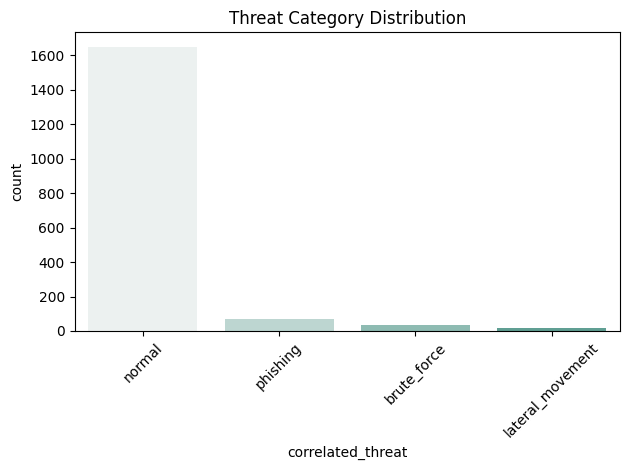

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='correlated_threat', palette='light:#5A9')
plt.xticks(rotation=45)
plt.title("Threat Category Distribution")
plt.tight_layout()
plt.show()


In [13]:
# === 3. Train Word2Vec model ===
# Ensure there are sentences to train on
if not df['tokens'].empty and any(len(t) > 0 for t in df['tokens']):
    print("\nTraining Word2Vec model...")
    # vector_size: dimension of the word embeddings
    # window: maximum distance between the current and predicted word within a sentence
    # min_count: ignores all words with total frequency lower than this
    # workers: use these many worker threads to train the model (=faster training)
    w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=1, workers=4)
    print("Word2Vec model training complete.")
else:
    print("No tokens found for Word2Vec training. Exiting.")
    exit()



Training Word2Vec model...
Word2Vec model training complete.


In [14]:
# === 4. Vectorize Text Data using Word2Vec ===
def vectorize_tokens(tokens, model):
    """
    Converts a list of tokens into a single vector by averaging Word2Vec embeddings.
    If no words are found in the model's vocabulary, returns a zero vector.
    """
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

print("\nVectorizing text data using Word2Vec...")
df['vector'] = df['tokens'].apply(lambda x: vectorize_tokens(x, w2v_model))
print("Text vectorization complete.")



Vectorizing text data using Word2Vec...
Text vectorization complete.


In [15]:
# === 5. Prepare Features (X) and Labels (y) ===
# X will be the stacked Word2Vec vectors
X = np.vstack(df['vector'].values)

# y will be the 'correlated_threat' column, which needs to be numerical
if 'correlated_threat' in df.columns:
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['correlated_threat'])
    target_names = label_encoder.classes_ # Get original class names
    print(f"\nLabels encoded. Original labels: {target_names}")
else:
    print("Error: 'correlated_threat' column not found. Cannot prepare labels.")
    exit()


# Split data into training and testing sets
# test_size=0.3 means 30% of data will be used for testing, 70% for training
# random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Data split into training ({len(X_train)} samples) and testing ({len(X_test)} samples) sets.")



Labels encoded. Original labels: ['brute_force' 'lateral_movement' 'normal' 'phishing']
Data split into training (1239 samples) and testing (531 samples) sets.


In [16]:
# === 6. Train & Evaluate Machine Learning Models ===
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Gaussian Naive Bayes": GaussianNB(),
    "SGD Classifier": SGDClassifier(random_state=42, max_iter=1000) # Added SGD Classifier
    # SVC, AdaBoostClassifier, GradientBoostingClassifier can also be added,
    # but might be computationally intensive or require more tuning.
}

print("\n--- Training and Evaluating Models ---")
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    print(f"\nResults for {name}:")
    # Evaluate model performance
    accuracy = accuracy_score(y_test, preds)
    conf_matrix = confusion_matrix(y_test, preds)
    class_report = classification_report(y_test, preds, target_names=target_names, zero_division=0) # zero_division=0 handles cases where no samples for a class in test set

    print(f"Accuracy: {accuracy:.4f}")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)


--- Training and Evaluating Models ---

=== Training Random Forest ===

Results for Random Forest:
Accuracy: 0.9906
Confusion Matrix:
 [[ 10   0   0   0]
 [  0   5   0   0]
 [  0   0 495   0]
 [  0   0   5  16]]
Classification Report:
                   precision    recall  f1-score   support

     brute_force       1.00      1.00      1.00        10
lateral_movement       1.00      1.00      1.00         5
          normal       0.99      1.00      0.99       495
        phishing       1.00      0.76      0.86        21

        accuracy                           0.99       531
       macro avg       1.00      0.94      0.96       531
    weighted avg       0.99      0.99      0.99       531


=== Training Logistic Regression ===

Results for Logistic Regression:
Accuracy: 0.9322
Confusion Matrix:
 [[  0   0  10   0]
 [  0   0   5   0]
 [  0   0 495   0]
 [  0   0  21   0]]
Classification Report:
                   precision    recall  f1-score   support

     brute_force       0.00 

In [1]:
import pandas as pd
import numpy as np
import json # Pour gérer les réponses JSON de l'API LLM

# === 1. Configuration de l'API LLM (Google Generative Language API) ===
API_KEY = "" # Clé API laissée vide, gérée par l'environnement Canvas pour gemini-2.0-flash
API_BASE_URL = "https://generativelanguage.googleapis.com/v1beta/models/"
MODEL = "gemini-2.0-flash" # Modèle LLM à utiliser
print(f"Modèle LLM configuré : {MODEL} via Google Generative Language API.")

# === 2. Chargement et Agrégation des événements de log bruts ===
# Nous utilisons le dataset que vous avez fourni, qui contient des événements bruts.
try:
    df_raw_logs = pd.read_csv("dataset_with_attacks.csv")
    print("Jeu de données 'dataset_with_attacks.csv' chargé avec succès.")
except FileNotFoundError:
    print("Erreur: 'dataset_with_attacks.csv' introuvable.")
    print("Veuillez vous assurer que le fichier est dans le répertoire correct.")
    exit()

# Convertir 'event_time' en datetime (colonne de timestamp dans dataset_with_attacks.csv)
df_raw_logs['event_time'] = pd.to_datetime(df_raw_logs['event_time'], errors='coerce')
df_raw_logs.dropna(subset=['event_time'], inplace=True) # Supprimer les lignes avec des timestamps invalides

# Remplir les 'user_account' manquants avec 'Unknown_User' pour l'agrégation
df_raw_logs['user_account'].fillna('Unknown_User', inplace=True)

# Définir 'event_time' comme index pour le rééchantillonnage
df_raw_logs.set_index('event_time', inplace=True)

# === Agrégation en profils d'activité horaires par utilisateur ===
print("\nAgrégation des logs bruts en profils d'activité horaires par utilisateur...")
hourly_user_profiles = df_raw_logs.groupby('user_account').resample('1H').agg(
    event_count=('event_id', 'count'), # Nombre d'événements
    total_bytes_sent=('bytes_sent_total', 'sum'),
    total_bytes_received=('bytes_received_total', 'sum'),
    # Utiliser lambda x: x.nunique() pour les colonnes catégorielles
    unique_security_actions=('security_action', lambda x: x.nunique() if x.notna().any() else 0),
    unique_event_categories=('event_category', lambda x: x.nunique() if x.notna().any() else 0),
    unique_dest_ips=('destination_ip_address', lambda x: x.nunique() if x.notna().any() else 0),
    unique_http_methods=('http_method', lambda x: x.nunique() if x.notna().any() else 0),
    # Ajoutez d'autres agrégations pertinentes de dataset_with_attacks.csv si nécessaire
)

hourly_user_profiles.reset_index(inplace=True)
hourly_user_profiles.rename(columns={'event_time': 'time_window_start'}, inplace=True)

# Supprimer les profils où aucun événement n'a eu lieu (event_count est 0)
hourly_user_profiles = hourly_user_profiles[hourly_user_profiles['event_count'] > 0].copy()

# Ajout des features basées sur le temps aux profils horaires
hourly_user_profiles['hour_of_day'] = hourly_user_profiles['time_window_start'].dt.hour
hourly_user_profiles['day_of_week'] = hourly_user_profiles['time_window_start'].dt.dayofweek
hourly_user_profiles['is_weekend'] = hourly_user_profiles['time_window_start'].dt.dayofweek.isin([5, 6]).astype(int)

# Renommer le DataFrame pour la suite du script
df_profiles = hourly_user_profiles
print(f"Création de {len(df_profiles)} profils d'activité horaires par utilisateur.")
print("\n5 premiers profils d'activité agrégés:")
print(df_profiles.head().to_markdown(index=False, numalign="left", stralign="left"))

# === 3. Préparation du Contexte pour le LLM (résumé de l'activité) ===
# Crée un résumé textuel détaillé de chaque profil d'activité horaire pour le LLM.
def create_profile_context(row):
    context = f"Heure de début: {row['time_window_start']}\n"
    context += f"Utilisateur: {row['user_account']}\n"
    context += f"Compte d'événements sur l'heure: {row['event_count']}\n"
    context += f"Total octets envoyés: {row['total_bytes_sent']}\n"
    context += f"Total octets reçus: {row['total_bytes_received']}\n"
    context += f"Actions de sécurité uniques: {row['unique_security_actions']}\n"
    context += f"Catégories d'événements uniques: {row['unique_event_categories']}\n"
    context += f"Adresses IP de destination uniques: {row['unique_dest_ips']}\n"
    context += f"Méthodes HTTP uniques: {row['unique_http_methods']}\n"
    context += f"Heure de la journée: {row['hour_of_day']}, Jour de la semaine: {row['day_of_week']} (0=Lundi, 6=Dimanche), Weekend: {'Oui' if row['is_weekend'] else 'Non'}\n"
    
    return context

print("\nPréparation du contexte textuel pour le LLM à partir des profils d'activité...")
df_profiles['llm_context'] = df_profiles.apply(create_profile_context, axis=1)
print("Contexte LLM préparé.")

# === 4. Définition de la fonction d'appel LLM pour la prédiction proactive ===
def ask_llm_proactive(profile_context):
    """
    Simule l'interrogation du LLM pour évaluer le potentiel de menace proactive
    d'un profil d'activité utilisateur.
    """
    # Dans un environnement réel, `system_prompt` et `user_prompt` seraient envoyés à l'API LLM.
    system_prompt = """Vous êtes un expert en intelligence des menaces de cybersécurité.
    Analysez le profil d'activité utilisateur fourni. Évaluez le niveau de menace potentiel
    indiqué par ces activités, en vous concentrant sur les signes précurseurs ou les étapes d'une attaque.

    Classez le profil d'activité comme l'un des stades de menace suivants:
    - NEUTRE (Activité normale, pas de signe de menace)
    - INDICE_FAIBLE (Activité légèrement inhabituelle, peut être un signe précoce ou du bruit)
    - PHASES_PREPARATOIRES (Indicateurs clairs d'une activité de reconnaissance ou de préparation d'attaque)
    - ATTAQUE_IMMINENTE (Très fortes preuves d'une attaque sur le point de se produire ou en cours de déploiement)
    - ATTAQUE_ACTIVE (L'attaque est en cours d'exécution)

    Expliquez brièvement votre raisonnement en une ou deux phrases.
    Format de sortie attendu: CLASSIFICATION_MENACE: Raisonnement.
    """
    
    user_prompt = f"Profil d'activité utilisateur:\n{profile_context}\n\nÉvaluez le niveau de menace potentiel et expliquez:"
    
    # --- Logique de simulation améliorée et plus diversifiée ---
    # Extraire les valeurs pour la simulation. Ajouter des blocs try-except pour la robustesse.
    event_count = 0.0
    bytes_sent = 0.0
    unique_actions = 0.0
    unique_ips = 0.0
    unique_http_methods = 0.0 # Ajout de l'extraction pour unique_http_methods

    try:
        event_count = float(profile_context.split("Compte d'événements sur l'heure: ")[1].split('\n')[0])
    except (IndexError, ValueError):
        pass
    try:
        bytes_sent = float(profile_context.split("Total octets envoyés: ")[1].split('\n')[0])
    except (IndexError, ValueError):
        pass
    try:
        unique_actions = float(profile_context.split("Actions de sécurité uniques: ")[1].split('\n')[0])
    except (IndexError, ValueError):
        pass
    try:
        unique_ips = float(profile_context.split("Adresses IP de destination uniques: ")[1].split('\n')[0])
    except (IndexError, ValueError):
        pass
    try:
        unique_http_methods = float(profile_context.split("Méthodes HTTP uniques: ")[1].split('\n')[0])
    except (IndexError, ValueError):
        pass
    
    # Règle pour ATTAQUE_ACTIVE (Exfiltration de données massive ou activité très agressive)
    if bytes_sent > 400000 and event_count > 100:
        return "ATTAQUE_ACTIVE: Volume très élevé d'octets envoyés et grand nombre d'événements, suggérant une exfiltration de données ou une attaque en cours."
    if unique_actions > 15 and unique_ips > 10 and event_count > 150: # Activité anormale multi-facettes
        return "ATTAQUE_ACTIVE: Combinaison anormale de nombreuses actions, IPs cibles et volume d'événements, indicatif d'une attaque en cours."

    # Règle pour ATTAQUE_IMMINENTE (Reconnaissance agressive ou mouvements suspects)
    if event_count > 80 and unique_ips > 7 and unique_actions > 8:
        return "ATTAQUE_IMMINENTE: Activité intense avec de nombreuses cibles et actions, signalant une phase de déploiement ou une menace immédiate."
    if bytes_sent > 50000 and unique_ips > 5: # Transfert de données significatif vers plusieurs cibles
        return "ATTAQUE_IMMINENTE: Transfert de données élevé vers diverses destinations, indiquant une préparation ou un mouvement latéral avancé."

    # Règle pour PHASES_PREPARATOIRES (Reconnaissance, balayage, faible nombre mais atypique)
    if event_count > 30 and (unique_ips > 3 or unique_actions > 5):
        return "PHASES_PREPARATOIRES: Activité modérée mais avec une diversité d'IPs ou d'actions, suggérant une reconnaissance ou une préparation."
    if unique_http_methods > 2 and unique_ips > 2: # Exploration web atypique
        return "PHASES_PREPARATOIRES: Utilisation variée de méthodes HTTP vers plusieurs IPs, potentiellement pour de la reconnaissance web."

    # Règle pour INDICE_FAIBLE (Anomalie mineure, bruit)
    if event_count > 10 or unique_actions > 2 or unique_ips > 1: # Activité légère mais hors norme
        return "INDICE_FAIBLE: Activité légèrement inhabituelle ou quelques indicateurs faibles, nécessitant une surveillance accrue."

    # Règle par défaut
    return "NEUTRE: L'activité semble normale et ne présente pas d'indicateurs de menace connus."


# === 5. Exécution sur un échantillon (ou toutes les données) ===
# ATTENTION : L'exécution sur l'ensemble du dataset avec une VRAIE API LLM peut être TRÈS LENTE ET COÛTEUSE.
# Pour la démonstration, nous utilisons un petit échantillon et une réponse simulée.

num_samples_to_take = 20
sample_profiles_df = df_profiles.sample(n=num_samples_to_take, random_state=42).copy() # Échantillonnage aléatoire simple

print(f"\nExécution de l'évaluation proactive de menace LLM sur {len(sample_profiles_df)} profils d'activité...")
sample_profiles_df['llm_threat_assessment'] = sample_profiles_df['llm_context'].apply(ask_llm_proactive)
print("Évaluation LLM terminée.")

# === 6. Extraction de la prédiction et de l'explication ===
# Utilise une expression régulière pour extraire le niveau de menace et l'explication
threat_pattern = r'(?i)(NEUTRE|INDICE_FAIBLE|PHASES_PREPARATOIRES|ATTAQUE_IMMINENTE|ATTAQUE_ACTIVE)[:\-]?\s*(.*)'
sample_profiles_df[['predicted_threat_stage', 'llm_explanation']] = sample_profiles_df['llm_threat_assessment'].str.extract(threat_pattern)

# Gérer les cas où l'extraction a échoué
sample_profiles_df['predicted_threat_stage'] = sample_profiles_df['predicted_threat_stage'].fillna('INCONNU')
sample_profiles_df['llm_explanation'] = sample_profiles_df['llm_explanation'].fillna('La sortie LLM n\'a pas pu être analysée ou une erreur s\'est produite.')


# === 7. Affichage des résultats ===
print("\n--- Résultats de l'évaluation proactive des menaces par LLM sur l'échantillon ---")
display_cols = [
    'time_window_start', 'user_account', 'event_count', 'total_bytes_sent',
    'unique_security_actions', 'predicted_threat_stage', 'llm_explanation', 'llm_threat_assessment'
]
display_cols = [col for col in display_cols if col in sample_profiles_df.columns]
print(sample_profiles_df[display_cols].to_markdown(index=False, numalign="left", stralign="left"))


# === 8. Sauvegarde des résultats ===
output_filename = "llm_proactive_threat_predictions_sample.csv"
sample_profiles_df.to_csv(output_filename, index=False)
print(f"\n[✓] Prédictions proactives de menaces sauvegardées dans {output_filename}")


Modèle LLM configuré : gemini-2.0-flash via Google Generative Language API.
Jeu de données 'dataset_with_attacks.csv' chargé avec succès.

Agrégation des logs bruts en profils d'activité horaires par utilisateur...


/tmp/ipykernel_679/1312827176.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_raw_logs['user_account'].fillna('Unknown_User', inplace=True)
/tmp/ipykernel_679/1312827176.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_user_profiles = df_raw_logs.groupby('user_account').resample('1H').agg(


Création de 1844 profils d'activité horaires par utilisateur.

5 premiers profils d'activité agrégés:
| user_account   | time_window_start   | event_count   | total_bytes_sent   | total_bytes_received   | unique_security_actions   | unique_event_categories   | unique_dest_ips   | unique_http_methods   | hour_of_day   | day_of_week   | is_weekend   |
|:---------------|:--------------------|:--------------|:-------------------|:-----------------------|:--------------------------|:--------------------------|:------------------|:----------------------|:--------------|:--------------|:-------------|
| Unknown_User   | 2025-05-26 09:00:00 | 224           | 794764             | 774301                 | 1                         | 12                        | 59                | 0                     | 9             | 0             | 0            |
| Unknown_User   | 2025-05-26 10:00:00 | 159           | 539347             | 421977                 | 1                         | 12               

/tmp/ipykernel_679/1312827176.py:33: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hourly_user_profiles = df_raw_logs.groupby('user_account').resample('1H').agg(
